# Star-Galaxy Classification

## Goal

The goal of this project is to use astronomical data to create a classification model. Given images of stars and galaxies, this model should accurately classify the heavenly bodies.

## Imports

The following block disables pesky warnings.

In [4]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

For this project we are using standard data science packages, some custom utility functions we wrote, and tensorflow.

In [5]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, losses, models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.utils import Bunch
from sklearn.decomposition import PCA

STAR = 0
GALAXY = 1
DATA_PATH = Path("/homes/pedroavalosjimenez/Public/ml-way/dataset")

%matplotlib inline

The following are helper functions that are more well-documented on [GitHub](https://github.com/pavalos/ml-way):

In [6]:
def star_galaxy_split(x, y):
    stars, galaxies = [], []
    for i, im in enumerate(x):
        if y[i] == STAR:
            stars.append(im.copy())
        elif y[i] == GALAXY:
            galaxies.append(im.copy())
    return np.asarray(stars), np.asarray(galaxies)


def train_val_test_split(
    x, y, train_size=0.8, test_size=0.5, stratify=None
):
    x_train, x_rest, y_train, y_rest = train_test_split(
        x, y, train_size=train_size, stratify=stratify
    )
    x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=test_size)
    return x_train, x_val, x_test, y_train, y_val, y_test



def load_star_galaxy_dataset(even=False):
    dataset = {}
    dataset["DESCR"] = (
        "This is a simple dataset consisting of ~3000 64x64 images of stars "
        "and ~1000 images of galaxies. The images were captured by the "
        "in-house 1.3m telescope of the observatory situated in Devasthal, "
        "Nainital, India."
    )
    dataset["filename"] = []
    dataset["image"] = []
    dataset["data"] = []
    dataset["target"] = []
    dataset["target_names"] = np.asarray(["star", "galaxy"])

    # Load each class of data into the dataset
    dataset_path: Path = _MODULE_PATH / "dataset"
    for y, target_name in enumerate(dataset["target_names"]):
        for file in (dataset_path / target_name).iterdir():
            im = np.asarray(Image.open(file).convert("L"))
            x = im.flatten()

            dataset["filename"].append(file.name)
            dataset["image"].append(im)
            dataset["data"].append(x)
            dataset["target"].append(y)

    # Convert dataset attributes to numpy arrays
    dataset["filename"] = np.asarray(dataset["filename"])
    dataset["image"] = np.asarray(dataset["image"])
    dataset["data"] = np.asarray(dataset["data"])
    dataset["target"] = np.asarray(dataset["target"])
    
    if even:
        stars, galaxies = star_galaxy_split(dataset["image"], dataset["target"])
        size = len(galaxies)
        stars = stars[np.random.choice(len(stars), size=size, replace=False)]
        image = np.concatenate((stars, galaxies), axis=0)
        data = np.asarray([im.flatten() for im in image])
        target = np.concatenate((np.full(size, STAR), np.full(size, GALAXY)), axis=0)
        return Bunch(
            DESCR=dataset["DESCR"],
            filename=dataset["filename"].copy(),
            image=image,
            data=data,
            target=target,
            target_names=dataset["target_names"].copy(),
        )
    
    return Bunch(**dataset)

Here are some helper functions for running and comparing models. Feel free to ignore them for now.

In [7]:
def train_test_model_knn(model, x, y):
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Fit Model
    model.fit(x_train, y_train)

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset.data, x, x_train, x_val, x_test],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        n = len(_x)
        label = f"{_name} ({n})"
        print(label)
        print("-" * len(label))
        print(f"overall ({n})", end="\t")
        print(model.score(_x, _y))

        stars, galaxies = star_galaxy_split(_x, _y)
        n_stars, n_galaxies = len(stars), len(galaxies)
        print(f"stars ({n_stars})", end="\t")
        print(model.score(stars, np.full(len(stars), STAR)))
        print(f"galaxies ({n_galaxies})", end="\t")
        print(model.score(galaxies, np.full(len(galaxies), GALAXY)))
        
        error_rates = []
        knn_models = []
        k_range = np.arange(1, 35)
        for k_neighbors in k_range:
            knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
            knn_model.fit(x_train, y_train)
            predictions = knn_model.predict(x_test)
            error_rates.append(np.mean(predictions != y_test))
            knn_models.append(knn_model)


        plt.title("Error Rates vs. K-Neighbors (lower is better)")
        plt.xlabel("K-Neighbors")
        plt.ylabel("Error Rate %")
        plt.plot(k_range, error_rates)

In [8]:
def train_test_model_logreg(model, x, y):
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Fit Model
    model.fit(x_train, y_train)

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset.data, x, x_train, x_val, x_test],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        n = len(_x)
        label = f"{_name} ({n})"
        print(label)
        print("-" * len(label))
        print(f"overall ({n})", end="\t")
        print(model.score(_x, _y))

        stars, galaxies = star_galaxy_split(_x, _y)
        n_stars, n_galaxies = len(stars), len(galaxies)
        print(f"stars ({n_stars})", end="\t")
        print(model.score(stars, np.full(len(stars), STAR)))
        print(f"galaxies ({n_galaxies})", end="\t")
        print(model.score(galaxies, np.full(len(galaxies), GALAXY)))
        
        error_rates = []
        lr_models = []
        Cs= [1,.8, .6, .5, .4, .2, .1,.05,.01, .001,.0001]
        for c in Cs:
            lr_model = LogisticRegression(random_state=0, C=c)
            lr_model.fit(x_train, y_train)
            predictions = lr_model.predict(x_test)
            error_rates.append(np.mean(predictions != y_test))
            lr_models.append(lr_model)


        plt.title("Error Rates vs. regularization (lower is better)")
        plt.xlabel("C")
        plt.ylabel("Error Rate %")
        plt.plot(Cs, error_rates)

In [9]:
def train_test_model_svm(model, x, y):
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Fit Model
    pca = PCA(n_components=20)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    x_val_pca = pca.transform(x_val)
    x_pca = pca.transform(x)
    dataset_pca = pca.transform(dataset.data)
    model.fit(x_train_pca, y_train)

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset_pca, x_pca, x_train_pca, x_val_pca, x_test_pca],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        n = len(_x)
        label = f"{_name} ({n})"
        print(label)
        print("-" * len(label))
        print(f"overall ({n})", end="\t")
        print(model.score(_x, _y))

        stars, galaxies = star_galaxy_split(_x, _y)
        n_stars, n_galaxies = len(stars), len(galaxies)
        print(f"stars ({n_stars})", end="\t")
        print(model.score(stars, np.full(len(stars), STAR)))
        print(f"galaxies ({n_galaxies})", end="\t")
        print(model.score(galaxies, np.full(len(galaxies), GALAXY)))

## Dataset

The dataset we selected consists of about 3,000 images of stars and about 1,000 images of galaxies. The images were captured by a telescope in India.

The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data).

### Load Dataset

Here we load the whole dataset here with our helper function.

In [10]:
# Load dataset
dataset = load_star_galaxy_dataset()
print(f"{dataset.DESCR}\n")
print(f"Dataset size: {len(dataset.image)} images")

NameError: name '_MODULE_PATH' is not defined

This is a helper function to show a certain number of images using matplotlib.

In [8]:
def plot_images(
    images,
    labels,
    ncols: int = 1,
    color: str = "black",
) -> None:
    """Helper function to show images."""

    n = len(images)
    fig = plt.figure(figsize=(8, 8))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        a = fig.add_subplot(int(np.ceil(n / ncols)), ncols, i + 1)
        a.imshow(img, cmap="gray")
        a.set_title(lbl, color=color)
        a.axis("off")
    plt.show()

Let's look at a random sample of images in the dataset.

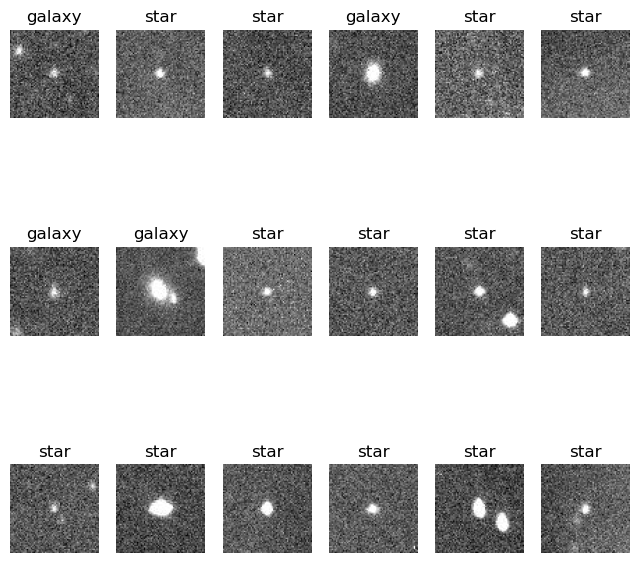

In [5]:
indices = np.random.choice(len(dataset.image), size=18)
plot_images(
    images=dataset.image[indices],
    labels=dataset.target_names[dataset.target[indices]],
    ncols=6,
)

## First approach with SKLearn

Lets start the task of classifying by comparing the performance of different SKLearn model families.

### KNN

KNN


FULL (3986)
-----------
overall (3986)	0.8409433015554441
stars (3044)	0.9694480946123522
galaxies (942)	0.4256900212314225

GIVEN (3986)
------------
overall (3986)	0.8409433015554441
stars (3044)	0.9694480946123522
galaxies (942)	0.4256900212314225

TRAIN (3188)
------------
overall (3188)	0.8601003764115432
stars (2435)	0.975770020533881
galaxies (753)	0.4860557768924303

VAL (399)
---------
overall (399)	0.7669172932330827
stars (308)	0.9512987012987013
galaxies (91)	0.14285714285714285

TEST (399)
----------
overall (399)	0.7619047619047619
stars (301)	0.9368770764119602
galaxies (98)	0.22448979591836735


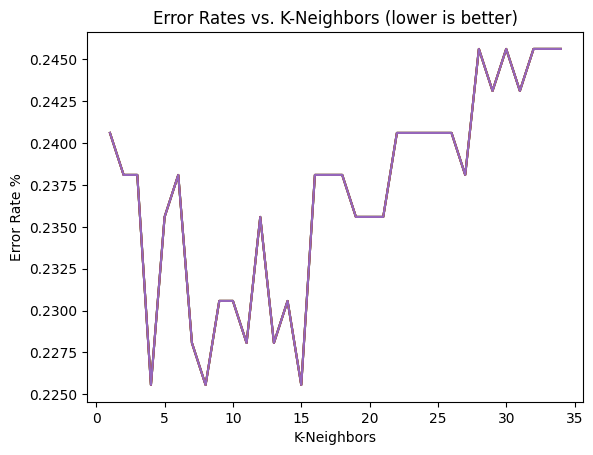

In [9]:
print("KNN\n")
model = KNeighborsClassifier(n_neighbors=3)
train_test_model_knn(model, dataset.data, dataset.target)

The model performs poorly on galaxies. In fact, the model decides that the image is a star most of the time, likely because of the much higher percentage of stars in the dataset. We will likely have to do something about this later...

Just for fun, lets look at some of the images that it got wrong...

Misclassified 634 images


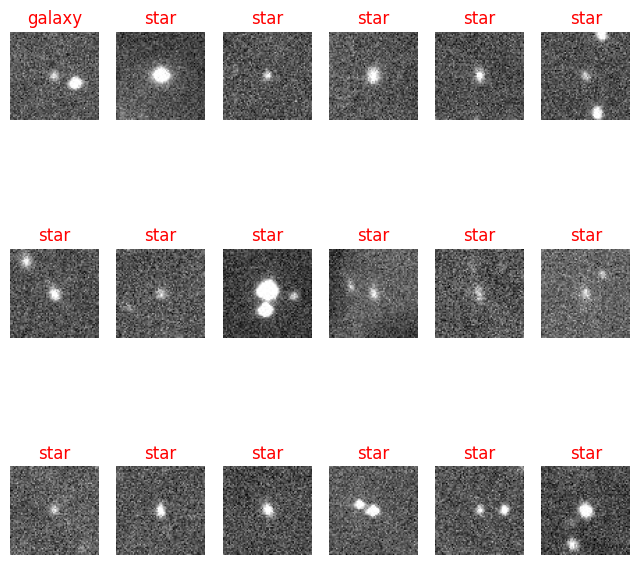

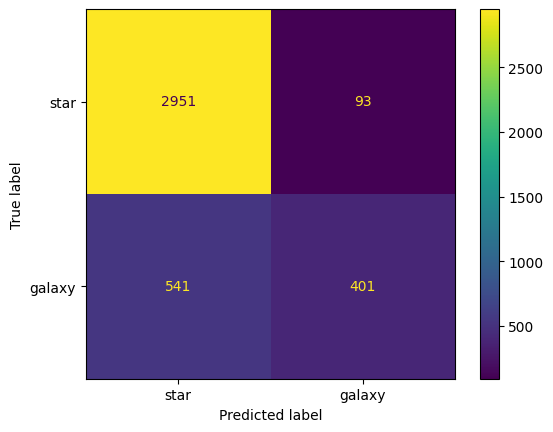

In [10]:
y_preds = model.predict(dataset.data)
mispreds = dataset.image[y_preds != dataset.target]
print(f"Misclassified {len(mispreds)} images")

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[y_preds[indices]],
    ncols=6,
    color="red",
)
cm = confusion_matrix(dataset.target, y_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=["star","galaxy"]).plot()

### Logistic Regression

LogReg


FULL (3986)
-----------
overall (3986)	0.9415454089312594
stars (3044)	0.9684625492772667
galaxies (942)	0.8545647558386412

GIVEN (3986)
------------
overall (3986)	0.9415454089312594
stars (3044)	0.9684625492772667
galaxies (942)	0.8545647558386412

TRAIN (3188)
------------
overall (3188)	1.0
stars (2435)	1.0
galaxies (753)	1.0

VAL (399)
---------
overall (399)	0.7167919799498746
stars (311)	0.8392282958199357
galaxies (88)	0.2840909090909091

TEST (399)
----------
overall (399)	0.6992481203007519
stars (298)	0.8456375838926175
galaxies (101)	0.26732673267326734


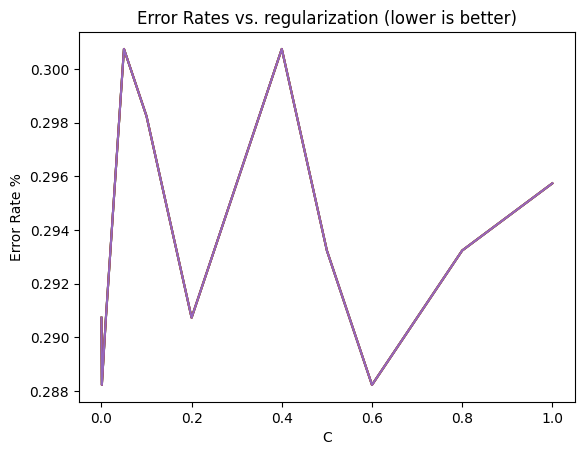

In [20]:
print("LogReg\n")
model = LogisticRegression(random_state=0, C=0.05)
train_test_model_logreg(model, dataset.data, dataset.target)

Once again, the model performs very poorly on galaxyies. This time the model is also overfit, even when using a strong regularization factor. Notice that the y-axis of the graph only covers a small interval, so the regularitzation factor does not have much influence.

Once again, lets look at what images it misclassified.

Misclassified 233 images


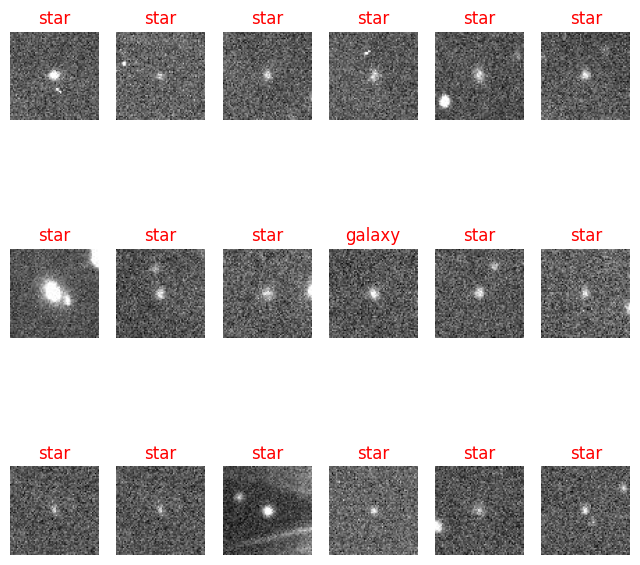

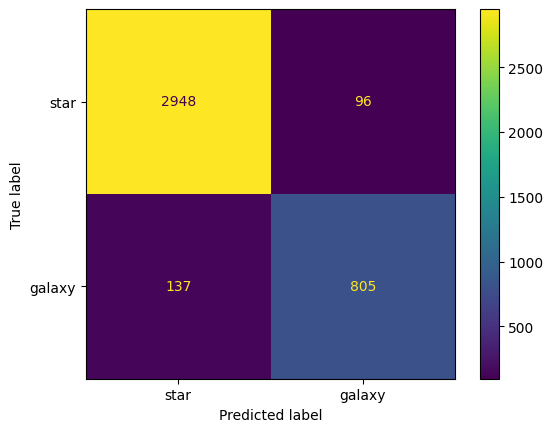

In [21]:
y_preds = model.predict(dataset.data)
mispreds = dataset.image[y_preds != dataset.target]
print(f"Misclassified {len(mispreds)} images")

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[y_preds[indices]],
    ncols=6,
    color="red",
)
cm = confusion_matrix(dataset.target, y_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=["star","galaxy"]).plot()

### SVM (With PCA)

SVM is very similar to logistic regression, so lets make things more interesting by adding in Pincipal comonent analysis.

SVM


FULL (3986)
-----------
overall (3986)	0.7636728549924736
stars (3044)	1.0
galaxies (942)	0.0

GIVEN (3986)
------------
overall (3986)	0.7636728549924736
stars (3044)	1.0
galaxies (942)	0.0

TRAIN (3188)
------------
overall (3188)	0.763801756587202
stars (2435)	1.0
galaxies (753)	0.0

VAL (399)
---------
overall (399)	0.7644110275689223
stars (305)	1.0
galaxies (94)	0.0

TEST (399)
----------
overall (399)	0.7619047619047619
stars (304)	1.0
galaxies (95)	0.0


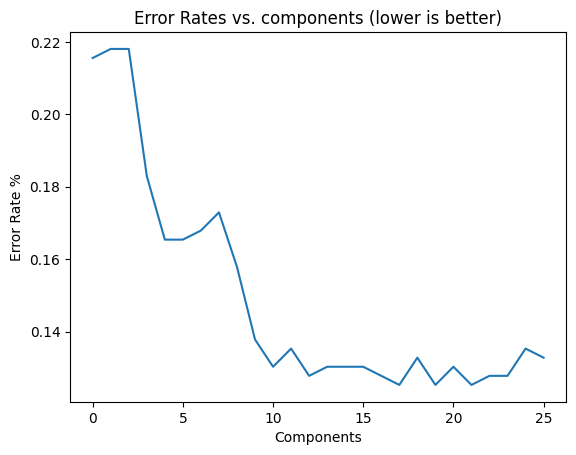

In [17]:
print("SVM with 20 components\n")
model = svm.SVC(kernel='linear', C=.0001)
train_test_model_svm(model, dataset.data, dataset.target)

# this code prints the graph
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    dataset.data,
    dataset.target,
    stratify=dataset.target,
)

error_rates = []
svm_models = []
pca_models = []
component_range = np.arange(0,26,1)
svm_model = svm.SVC()
svm_model.fit(x_train, y_train)
predictions = svm_model.predict(x_test)
error_rates.append(np.mean(predictions != y_test))
for k_components in component_range:
    if (k_components == 0):
        continue
    svm_model = svm.SVC()
    pca = PCA(n_components=k_components)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    svm_model.fit(x_train_pca, y_train)
    predictions = svm_model.predict(x_test_pca)
    error_rates.append(np.mean(predictions != y_test))
    svm_models.append(svm_model)
    
plt.title("Error Rates vs. components (lower is better)")
plt.xlabel("Components")
plt.ylabel("Error Rate %")
plt.plot(component_range, error_rates)

Whoa, something is very wrong here. It guesses that everything is a star. The graph is misleading, as it appears that using more components is helping the model, but in reality it is just increasing the percentage of images that are classified as star, and since stars are a majority of the dataset, we can get a relatively good error rate.

# CNN
 
Lets try CNNs, their specialty is image data, so maybe it will be helpful here with a tricky dataset

## Building the Model 

### Layers

Much like an onion or an ogre, a CNN model consists of layers.

The first few layers work with the input images more intuitively. The model takes in grayscale images, rescaling the `[0, 255]` values to `[0, 1]` (in both training and inference).

This function helps us create a new model to train with the same layers every time.

In [6]:
def create_model() -> tf.keras.Model:
    """Creates and compiles a CNN model."""
    
    model = models.Sequential(
        [
            # Input Layers
            layers.Input(shape=(64, 64, 1), name="input"),
            layers.Rescaling(scale=(1.0 / 255), name="rescale"),
            # Convolution Layers
            layers.Conv2D(
                filters=32, kernel_size=3, activation="relu", name="conv2d_1"
            ),
            layers.Conv2D(
                filters=64, kernel_size=3, activation="relu", name="conv2d_2"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_1"),
            layers.Dropout(rate=0.25, name="dropout_1"),
            layers.Conv2D(
                filters=64, kernel_size=3, activation="relu", name="conv2d_3"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_2"),
            layers.Dropout(rate=0.25, name="dropout_2"),
            layers.Conv2D(
                filters=128, kernel_size=3, activation="relu", name="conv2d_4"
            ),
            layers.MaxPool2D(pool_size=2, name="maxpool_3"),
            layers.Dropout(rate=0.25, name="dropout_3"),
            # Deep Learning Layers
            layers.Flatten(name="flatten"),
            layers.Dense(
                units=1024,
                activation="relu",
                name="dense_1",
            ),
            layers.Dropout(rate=0.5, name="dropout_4"),
            # Output Layer
            layers.Dense(units=2, name="output"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

Let's instantiate a model.

In [7]:
model = create_model()

Keras provides us with a handy-dandy function to visualize our model. Let's see these layers.

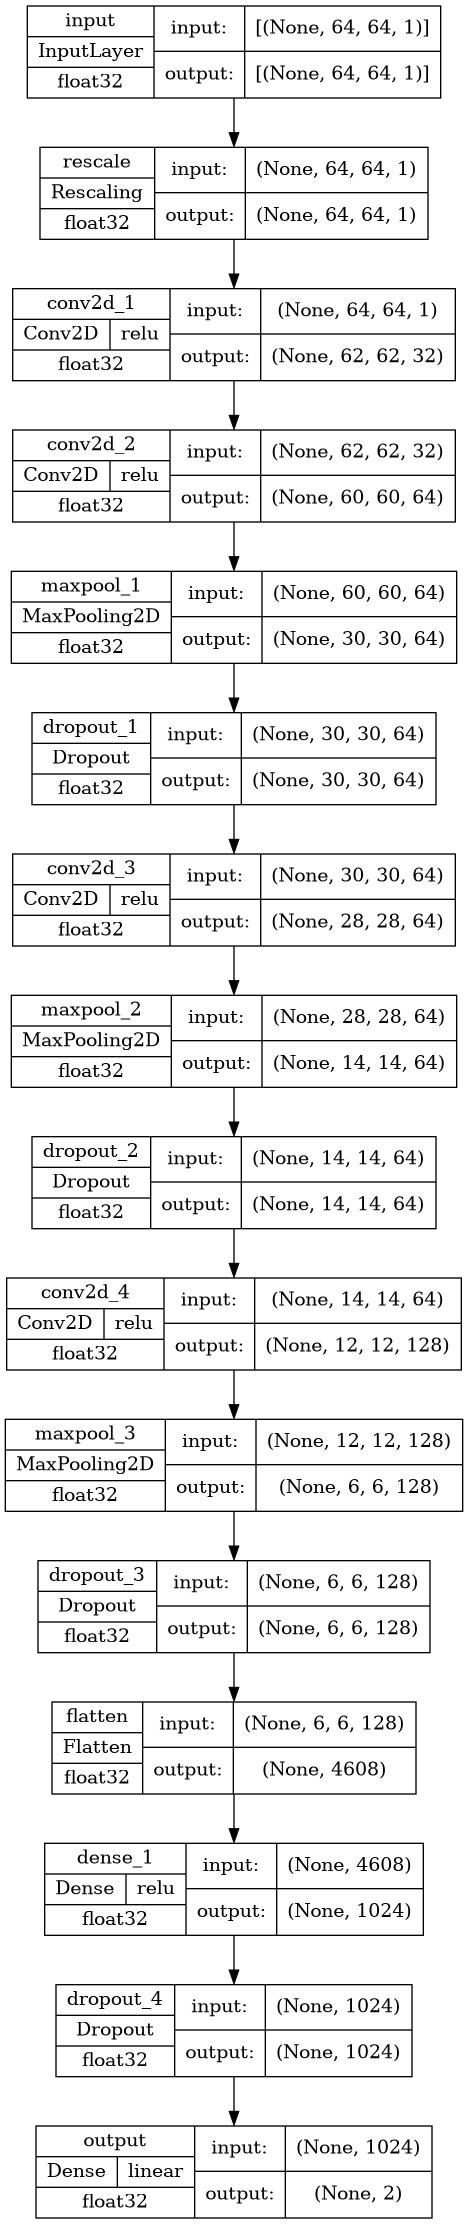

In [8]:
tf.keras.utils.plot_model(
    model=model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
)

## Training the Model

This is a helper function to both train and evaluate a model instance.

In [9]:
def train_test_model(model: tf.keras.Model, x, y, epochs: int = 30) -> tf.keras.callbacks.History:
    """Trains and evaluates a model."""
    
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Train model
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1,
    )

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset.image, x, x_train, x_val, x_test],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        n = len(_x)
        label = f"{_name} ({n})"
        print(label)
        print("-" * len(label))
        print(f"overall ({n})", end="\t")
        model.evaluate(_x, _y, verbose=2)

        stars, galaxies = star_galaxy_split(_x, _y)
        n_stars, n_galaxies = len(stars), len(galaxies)
        print(f"stars ({n_stars})", end="\t")
        model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
        print(f"galaxies ({n_galaxies})", end="\t")
        model.evaluate(galaxies, np.full(len(galaxies), GALAXY), verbose=2)

    return history

This is a helper function to display how the model performed with each epoch in training.

In [10]:
def plot_history(history: tf.keras.callbacks.History) -> None:
    """Display the history of a model's training."""
    
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel("epoch")
    plt.show()

Let's train the model and see how it performs with relevant subsets of the dataset.

In [11]:
history = train_test_model(model=model, x=dataset.image, y=dataset.target)

Epoch 1/30
100/100 [==============================] - 9s 35ms/step - loss: 0.5487 - accuracy: 0.7604 - val_loss: 0.4735 - val_accuracy: 0.7719
Epoch 2/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3927 - accuracy: 0.8115 - val_loss: 0.3518 - val_accuracy: 0.8271
Epoch 3/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3663 - accuracy: 0.8416 - val_loss: 0.3551 - val_accuracy: 0.8321
Epoch 4/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3334 - accuracy: 0.8541 - val_loss: 0.3657 - val_accuracy: 0.8296
Epoch 5/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3210 - accuracy: 0.8629 - val_loss: 0.3184 - val_accuracy: 0.8521
Epoch 6/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2979 - accuracy: 0.8770 - val_loss: 0.3166 - val_accuracy: 0.8647
Epoch 7/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2913 - accuracy: 0.8767 - val_loss: 0.2858 - val_accuracy: 0.8797

Well it's not perfect, but it is a lot better than we experienced on the SKLearn classifiers!

## Evaluating the Model

Let's see how the model performed with each epoch.

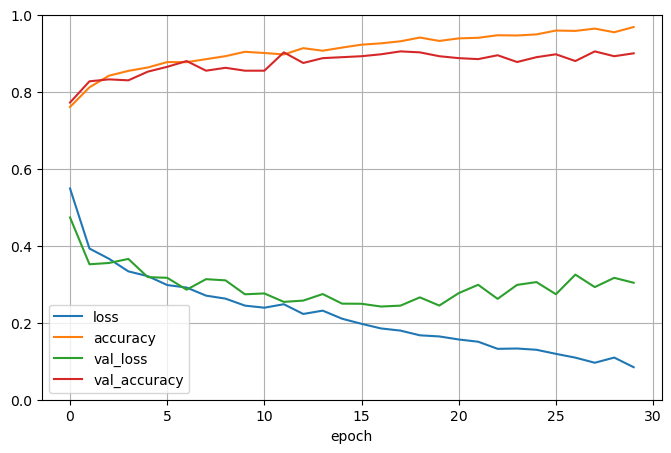

In [12]:
plot_history(history=history)

Let's see a random sample of images it is misclassifying.

Misclassified 102 images


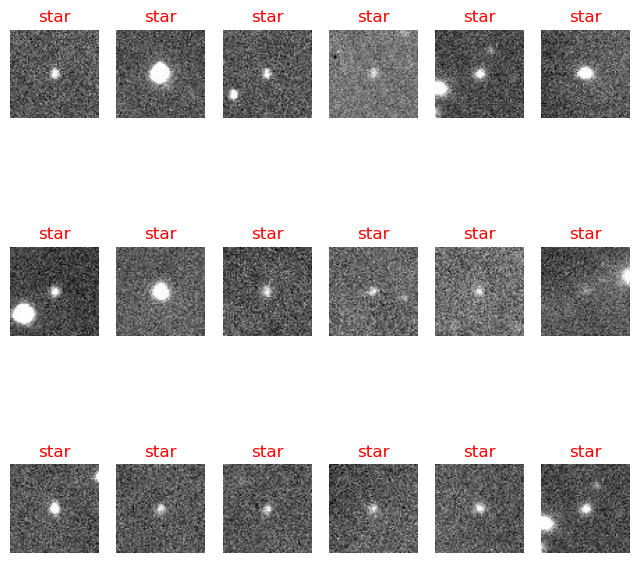

In [13]:
y_preds = np.argmax(model.predict(dataset.image, verbose=0), axis=1)
mispreds = dataset.image[y_preds != dataset.target]
print(f"Misclassified {len(mispreds)} images")

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds[indices],
    labels=dataset.target_names[y_preds[indices]],
    ncols=6,
    color="red",
)

To better visualize the error of the model, let's make what is called a "Confusion Matrix" or "Error Matrix". Here is a helper function to visualize a Confusion Matrix

In [14]:
def plot_conf_matrix(cm, labels):
    """Plots a confusion matrix with the given labels."""
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap("Blues")

    fig = plt.figure()
    axs = fig.add_subplot(111)

    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    thresh = np.max(cm) / 1.5

    caxs = axs.matshow(cm, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    fig.colorbar(caxs)

    plt.title("Confusion Matrix")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4}; misclass={misclass:0.4}")
    plt.ylabel("True label")

    ticklabels = np.concatenate(([""], labels))
    axs.set_xticklabels(ticklabels)
    axs.set_yticklabels(ticklabels)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            f"{cm[i,j]:0.4}",
            ha="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.show()

Here is the confusion matrix for the model:

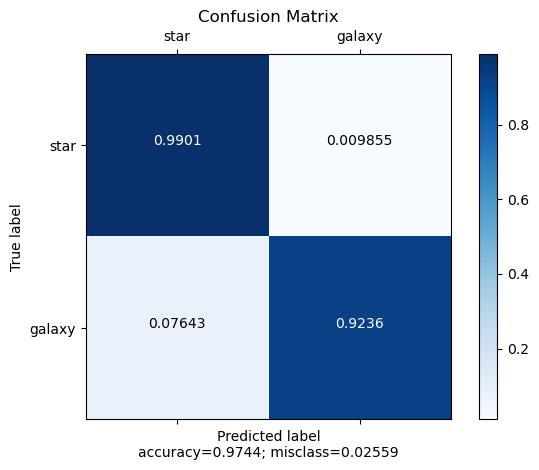

In [15]:
conf_matrix = tf.math.confusion_matrix(
    dataset.target,
    y_preds,
    num_classes=2,
)

plot_conf_matrix(cm=conf_matrix, labels=dataset.target_names)

## Problem

We're in a better place than we started, so lets grab hold of CNNs and see if we can improve it!

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 3/4 chance of being right.

In [16]:
all_stars, all_galaxies = star_galaxy_split(dataset.image, dataset.target)
print(f"stars: {len(all_stars)} images")
print(f"galaxies: {len(all_galaxies)} images")

stars: 3044 images
galaxies: 942 images


## Attempt at a Solution

Our attempt at solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing. Our function to load the dataset is able to do this for us, so let's create an "even" dataset.

In [17]:
dataset_even = load_star_galaxy_dataset(even=True)
print(f"'Even' dataset size: {len(dataset_even.image)} images")

'Even' dataset size: 1884 images


Now let's make a model and train it just like before.

In [18]:
model_even = create_model()

history_even = train_test_model(
    model=model_even, x=dataset_even.image, y=dataset_even.target
)

Epoch 1/30
48/48 [==============================] - 4s 39ms/step - loss: 0.6993 - accuracy: 0.5328 - val_loss: 0.6892 - val_accuracy: 0.5213
Epoch 2/30
48/48 [==============================] - 1s 27ms/step - loss: 0.6821 - accuracy: 0.5567 - val_loss: 0.6693 - val_accuracy: 0.5160
Epoch 3/30
48/48 [==============================] - 1s 26ms/step - loss: 0.5994 - accuracy: 0.6788 - val_loss: 0.5040 - val_accuracy: 0.7872
Epoch 4/30
48/48 [==============================] - 1s 26ms/step - loss: 0.4863 - accuracy: 0.7870 - val_loss: 0.4353 - val_accuracy: 0.8085
Epoch 5/30
48/48 [==============================] - 1s 26ms/step - loss: 0.4584 - accuracy: 0.8009 - val_loss: 0.4965 - val_accuracy: 0.8085
Epoch 6/30
48/48 [==============================] - 1s 26ms/step - loss: 0.4110 - accuracy: 0.8202 - val_loss: 0.4690 - val_accuracy: 0.8298
Epoch 7/30
48/48 [==============================] - 1s 26ms/step - loss: 0.3868 - accuracy: 0.8434 - val_loss: 0.4060 - val_accuracy: 0.8245
Epoch 8/30
48

Another big improvement, even when using only a portion of the dataset to train!

Let's see the performance with each epoch. 

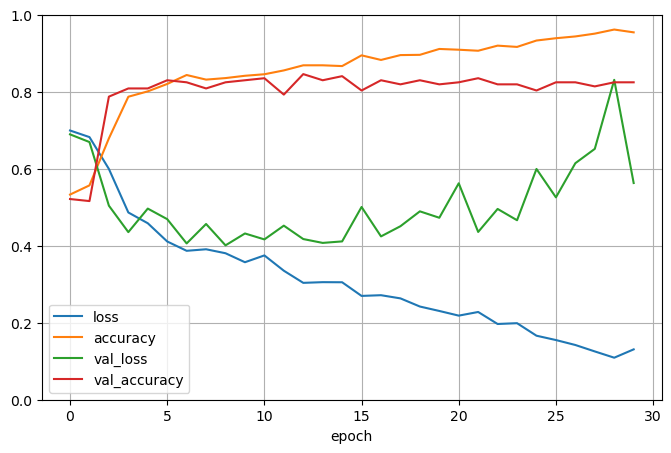

In [19]:
plot_history(history=history_even)

And now let's see a sample of the images it misclassified.

Misclassified 102 images


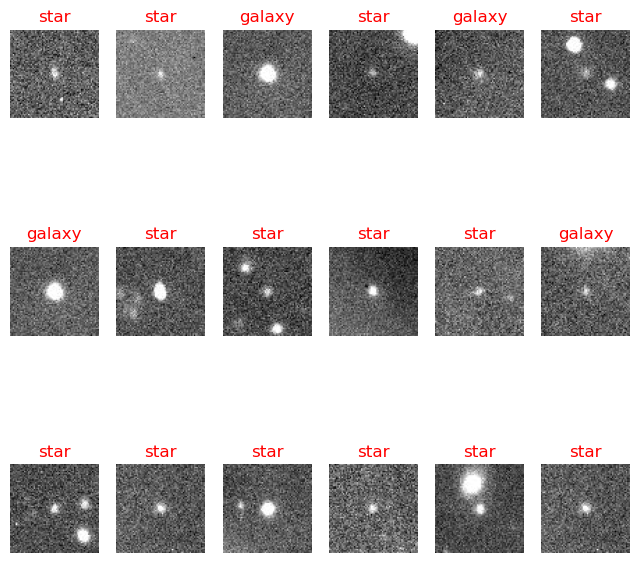

In [20]:
y_preds_even = np.argmax(model_even.predict(dataset.image, verbose=0), axis=1)
mispreds_even = dataset.image[y_preds != dataset.target]
print(f"Misclassified {len(mispreds_even)} images")

indices = np.random.choice(len(mispreds), size=18)
plot_images(
    images=mispreds_even[indices],
    labels=dataset.target_names[y_preds_even[indices]],
    ncols=6,
    color="red",
)

And a confusion matrix to more accurately visualize the errors.

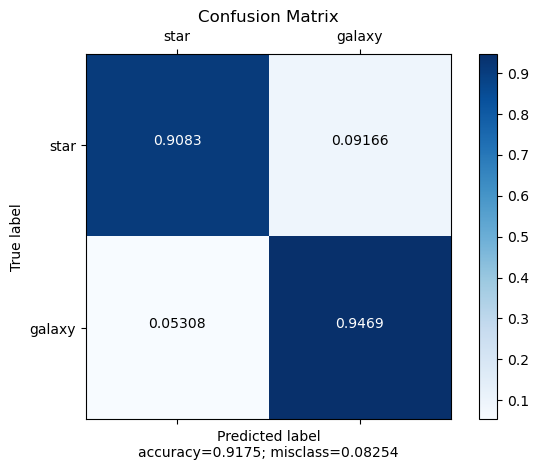

In [21]:
conf_matrix_even = tf.math.confusion_matrix(
    dataset.target,
    y_preds_even,
    num_classes=2,
)

plot_conf_matrix(cm=conf_matrix_even, labels=dataset.target_names)

Wow, now the model is performing better on 

## Conclusions

We learned the importance of having a large, balanced dataset. It was a real challenge to firstly work on an uneven dataset, and then to work on a small dataset afer evening things out. The surprising ineffectiveness of regularization on logistic regression and PCA on SVM shows how sometimes typical model families applied to poor data just produces bad models. Recall the resume analysis model from our ethics discussion.

A second conclusion is the power of CNN image classification. We were very impressed that CNN was able to turn around our project and make it even somewhat successful. Deciding what layers to choose was trial and error, and it was often hard to make sense of why something worked and others did not. For example, we attempted to rotate the images, add more dense layers, and more. But in our case it was more effective just to make the existing layers thicker.



